In [ ]:
from numpy import zeros
from numpy import ones
from numpy.random import randn
from numpy.random import randint
from keras.datasets.cifar10 import load_data
from keras.optimizers import Adam
from keras.models import Sequential
from keras.layers import Dense, Reshape, Flatten, Conv2D, Conv2DTranspose, LeakyReLU, Dropout

In [ ]:
import matplotlib.pyplot as plt

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
(train_X, train_y), (test_X, test_y) = load_data()

170498071/170498071 [==============================] - 2s 0us/step


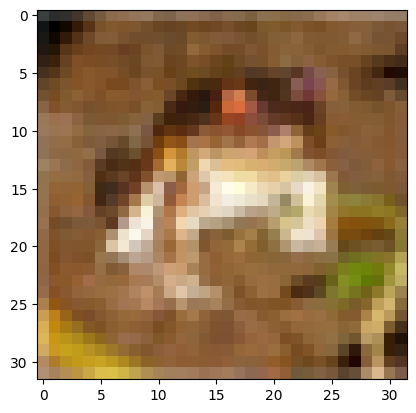

In [ ]:
plt.imshow(train_X[0])

In [ ]:
train_y[0]

array([6], dtype=uint8)

In [ ]:
def define_discriminator():
  model = Sequential()
  model.add(Conv2D(128, (3, 3), padding='same', input_shape= (32, 32, 3)))
  model.add(LeakyReLU(0.2))
  model.add(Conv2D(128, (3, 3), padding='same'))
  model.add(LeakyReLU(0.2))


  model.add(Flatten())
  model.add(Dropout(0.4))
  model.add(Dense(1, activation='sigmoid'))

  opt = Adam(lr=0.0002)
  model.compile(loss = 'binary_crossentropy', optimizer =opt, metrics=['accuracy'])

  return model


discr = define_discriminator()
print(discr.summary())



Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 32, 32, 128)       3584      
                                                                 
 leaky_re_lu (LeakyReLU)     (None, 32, 32, 128)       0         
                                                                 
 conv2d_1 (Conv2D)           (None, 32, 32, 128)       147584    
                                                                 
 leaky_re_lu_1 (LeakyReLU)   (None, 32, 32, 128)       0         
                                                                 
 flatten (Flatten)           (None, 131072)            0         
                                                                 
 dropout (Dropout)           (None, 131072)            0         
                                                                 
 dense (Dense)               (None, 1)                 1

/usr/local/lib/python3.10/dist-packages/keras/optimizers/legacy/adam.py:117: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


In [ ]:
def define_generator(latent_dim):
  model = Sequential()
  model.add(Dense(8192, input_dim=latent_dim))
  model.add(LeakyReLU(0.2))
  model.add(Reshape((8, 8, 128)))
  model.add(Conv2DTranspose(128, (4, 4), strides=(2, 2), padding='same'))
  model.add(LeakyReLU(0.2))
  model.add(Conv2DTranspose(128, (4, 4), strides=(2, 2), padding='same'))
  model.add(LeakyReLU(0.2))

  model.add(Conv2D(3, (8, 8), activation='tanh', padding='same'))

  return model



gen = define_generator(100)
print(gen.summary())




Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_1 (Dense)             (None, 8192)              827392    
                                                                 
 leaky_re_lu_2 (LeakyReLU)   (None, 8192)              0         
                                                                 
 reshape (Reshape)           (None, 8, 8, 128)         0         
                                                                 
 conv2d_transpose (Conv2DTra  (None, 16, 16, 128)      262272    
 nspose)                                                         
                                                                 
 leaky_re_lu_3 (LeakyReLU)   (None, 16, 16, 128)       0         
                                                                 
 conv2d_transpose_1 (Conv2DT  (None, 32, 32, 128)      262272    
 ranspose)                                            

In [ ]:
def define_gan(generator, discriminator):
  discriminator.trainable = False

  model = Sequential()
  model.add(generator)
  model.add(discriminator)

  opt = Adam(lr=0.0002)
  model.compile(loss = 'binary_crossentropy', optimizer =opt, metrics=['accuracy'])

  return model


In [ ]:
def load_real_samples():
  (train_X, _), (_, _) = load_data()
  X = train_X.astype('float32')

  X = (X - 127.5) / 127.5


  return X

In [ ]:
def generate_real_samples(dataset, n_samples):
  ix = randint(0, dataset.shape[0], n_samples)
  X = dataset[ix]
  y = ones((n_samples, 1))

  return X, y

In [ ]:
def generate_latent_points(latent_dim, n_samples):
  X_input = randn(latent_dim*n_samples)
  X_input = X_input.reshape(n_samples, latent_dim)

  return X_input

In [ ]:
def generate_fake_samples(generator, latent_dim, n_samples):
  X_input = generate_latent_points(latent_dim, n_samples)
  X = generator.predict(X_input)
  y = zeros((n_samples, 1 ))
  return X, y

In [ ]:
def train(g_model, d_model, gan_model, dataset, latent_dim,n_epochs=6, n_batch=128 ):
  bat_per_epo = int(dataset.shape[0] / n_batch)
  #bat_per_epo = 100 # for time

  half_batch = int(n_batch / 2)

  for i in range(n_epochs):
    for j in range(bat_per_epo):
      X_real, y_real = generate_real_samples(dataset, half_batch)
      d_loss_real, _ = d_model.train_on_batch(X_real, y_real)

      X_fake, y_fake  = generate_fake_samples(g_model, latent_dim, half_batch)
      d_loss_fake, _ = d_model.train_on_batch(X_fake, y_fake)


      X_gan = generate_latent_points(latent_dim, n_batch)
      y_gan = ones((n_batch, 1))

      g_loss = gan_model.train_on_batch(X_gan, y_gan)

      print(i+1, j+1, bat_per_epo, d_loss_real, d_loss_fake, g_loss)

  g_model.save('/content/drive/MyDrive/mnist_model/generator_model.h5')

In [ ]:
latent_dim = 100
discriminator = define_discriminator()
generator = define_generator(latent_dim)
gan_model = define_gan(generator, discriminator)
dataset = load_real_samples()
train(generator, discriminator, gan_model, dataset, latent_dim, n_epochs=2)

2/2 [==============================] - 1s 375ms/step
1 1 390 0.6954566240310669 0.7067149877548218 [0.6761689186096191, 1.0]
2/2 [==============================] - 1s 361ms/step
1 2 390 0.3232457637786865 0.7496169805526733 [0.6376867294311523, 1.0]
2/2 [==============================] - 1s 401ms/step
1 3 390 0.15578612685203552 0.8126343488693237 [0.5959173440933228, 1.0]
2/2 [==============================] - 1s 368ms/step
1 4 390 0.07601724565029144 0.8592456579208374 [0.5853825807571411, 1.0]
2/2 [==============================] - 1s 398ms/step
1 5 390 0.040065277367830276 0.8266913294792175 [0.6457777619361877, 1.0]
2/2 [==============================] - 1s 381ms/step
1 6 390 0.026847146451473236 0.6871199607849121 [0.8190762996673584, 0.0]
2/2 [==============================] - 1s 398ms/step
1 7 390 0.025668738409876823 0.48495572805404663 [1.139489769935608, 0.0]
2/2 [==============================] - 1s 388ms/step
1 8 390 0.02181592583656311 0.332628458738327 [1.475598573684692

In [ ]:
import keras
g_model = keras.models.load_model('/content/drive/MyDrive/mnist_model/generator_model.h5')



In [ ]:
#ref: https://github.com/bnsreenu/python_for_microscopists/blob/master/248_keras_implementation_of_GAN/248-cifar_GAN.py